In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

In [2]:
def tunnel_volume(h: float) -> float:
    """
    Compute tunnel volume [m³] as a function of water level h [m].

    Piecewise definition from HSY spec:
      - 0   ≤ h ≤ 0.4   : constant 350 m³
      - 0.4 < h ≤ 6.0   : V = (((1000 * (h - 0.4)**2) / 2) * 5) + 350
      - 6.0 < h ≤ 8.7   : V = (5500 * (h - 5.9) * 5) + 75975
      - 8.7 < h ≤ 14.1  : V = (((5.5 * 5500 / 2)
                                - ((5.5 - (h - 8.6))**2 * 1000 / 2)) * 5) \
                               + 150225
    """
    if h < 0:
        raise ValueError("Water level h cannot be negative")

    # 0 – 0.4 m
    if h <= 0.4:
        return 350.0

    # 0.4 – 6 m
    if h <= 6.0:
        return (((1000.0 * (h - 0.4)**2) / 2.0) * 5.0) + 350.0

    # 6 – 8.7 m
    if h <= 8.7:
        return (5500.0 * (h - 5.9) * 5.0) + 75975.0

    # 8.7 – 14.1 m
    if h <= 14.1:
        return (((5.5 * 5500.0 / 2.0)
                 - ((5.5 - (h - 8.6))**2 * 1000.0 / 2.0)) * 5.0) + 150225.0

    # Above design range
    raise ValueError("Water level h exceeds model range (h > 14.1 m)")

In [62]:
# There is a hack now to overcome a bug from the numerical fit
# If the volume is less than 350, the function returns 0.4
# This is not correct, but it is close enough for our purposes



def tunnel_height_from_volume(V):
    """
    Numerically invert tunnel_volume(h) to solve for h.
    If V <= 350 (minimum physical volume), return 0.4 immediately.
    """

    # Minimum possible volume from your tunnel_volume(h)
    V_min = 350.0

    # Clamp low volumes
    if V <= V_min:
        return 0.4   # the water level corresponding to the flat 350 m³ segment

    # Define root function
    def f(h):
        return tunnel_volume(h) - V

    # Solve safely
    try:
        return brentq(f, 0.0, 14.1)
    except ValueError:
        # If, for any reason, the root is not bracketed, fall back to safest bound
        return 0.4


In [66]:
tunnel_height_from_volume(351)

0.4199999999999999

In [4]:
tunnel_height_from_volume(10000)

2.36468827043885

In [5]:
# Read data in Hackathon_HSY_data.xlsx

df = pd.read_excel('Hackathon_HSY_data.xlsx', header=0, skiprows=[1])


df.keys()

Index(['Time stamp', 'Water level in tunnel L2', 'Water volume in tunnel V',
       'Sum of pumped flow to WWTP F2', 'Inflow to tunnel F1', 'Pump flow 1.1',
       'Pump flow 1.2', 'Pump flow 1.3', 'Pump flow 1.4', 'Pump flow 2.1',
       'Pump flow 2.2', 'Pump flow 2.3', 'Pump flow 2.4',
       'Pump efficiency 1.1', 'Pump efficiency 1.2', 'Pump efficiency 1.3',
       'Pump efficiency 1.4', 'Pump efficiency 2.1', 'Pump efficiency 2.2',
       'Pump efficiency 2.3', 'Pump efficiency 2.4', 'Pump frequency 1.1',
       'Pump frequency 1.2', 'Pump frequency 1.3', 'Pump frequency 1.4',
       'Pump frequency 2.1', 'Pump frequency 2.2', 'Pump frequency 2.3',
       'Pump frequency 2.4', 'Electricity price 1: high',
       'Electricity price 2: normal'],
      dtype='object')

In [6]:
efficiency_columns = [
    'Pump efficiency 1.1', 'Pump efficiency 1.2', 'Pump efficiency 1.3',
    'Pump efficiency 1.4', 'Pump efficiency 2.1', 'Pump efficiency 2.2',
    'Pump efficiency 2.3', 'Pump efficiency 2.4'
]
df['Total Effect'] = df[efficiency_columns].sum(axis=1)

flow_columns = [
    'Pump flow 1.1', 'Pump flow 1.2', 'Pump flow 1.3', 'Pump flow 1.4',
    'Pump flow 2.1', 'Pump flow 2.2', 'Pump flow 2.3', 'Pump flow 2.4'
]
df['Total flow'] = df[flow_columns].sum(axis=1)

In [172]:
start_time = 0

end_time = start_time + 96

future_electricity_prices=df['Electricity price 2: normal'].iloc[start_time:end_time].values

future_electricity_prices

inflow_to_tunnel_f1=df['Inflow to tunnel F1'].iloc[start_time:end_time].values

inflow_to_tunnel_f1


# This will be for more detailed data in the future:
#df_subset = df.iloc[start_time:end_time].copy()

# We have 6 large pumps and 2 small pumps.
# As a first approximation, the small pumps are 200kW and the large ones are 400kW.
# Thus a small one is one "quantum" and a large one is two quanta.
total_quanta_in_pumping=6*2+2*1

initial_water_level=df['Water level in tunnel L2'].iloc[start_time]
initial_volume=df['Water volume in tunnel V'].iloc[start_time]

# In the first approximation, we assume that the pumps always run at full power.
# And that they suck a certain amount of water per quantum.

pump_flow_per_quantum=16000/5/2

total_inflow_in_next_24_hours=df['Inflow to tunnel F1'].iloc[start_time:end_time].sum()

total_inflow_in_next_24_hours



np.float64(97178.63220214844)

In [173]:
Nstrategies=20
Ntime=96


pumping_strategies=np.ones((Nstrategies,Ntime))
pumping_costs=np.zeros((Nstrategies,Ntime))
levels_min=np.zeros((Nstrategies,Ntime))
levels_max=np.zeros((Nstrategies,Ntime))


for i in np.arange(1,pumping_strategies.shape[0]):
    electricity_price_running_mean_2h_1=df['Electricity price 1: high'].iloc[start_time:end_time].rolling(window=8+i).mean()
    electricity_price_running_mean_2h_2=df['Electricity price 2: normal'].iloc[start_time:end_time].rolling(window=8+i).mean()
    min_index_1=np.argmin(electricity_price_running_mean_2h_1)
    min_index_2=np.argmin(electricity_price_running_mean_2h_2)
    pumping_strategies[i,min_index_1-7-i:min_index_1+1]=10
    pumping_strategies[i,min_index_2-7-i:min_index_2+1]=10


Nstrategies=10000
Ntime=96
levels_min=np.zeros((Nstrategies))
levels_max=np.zeros((Nstrategies))

pumping_strategies=np.ones((Nstrategies,Ntime))
pumping_costs=np.zeros((Nstrategies,Ntime))

for i in range(pumping_strategies.shape[0]):
    maxrand=np.random.randint(2,11)

    for j in range(pumping_strategies.shape[1]):
        pumping_strategies[i,j]=np.random.randint(1,maxrand)

In [131]:
print(pumping_strategies[-1,:])

print(pumping_strategies[5,:])



[5. 1. 2. 7. 7. 5. 4. 6. 9. 3. 1. 1. 4. 5. 3. 2. 2. 6. 8. 4. 1. 6. 4. 2.
 1. 1. 1. 6. 4. 4. 2. 3. 5. 1. 3. 3. 5. 2. 2. 4. 6. 3. 1. 3. 4. 3. 3. 2.
 4. 7. 3. 2. 4. 1. 5. 6. 3. 5. 1. 8. 2. 1. 4. 2. 7. 3. 3. 1. 5. 4. 5. 2.
 8. 1. 2. 2. 2. 1. 1. 1. 2. 4. 4. 3. 3. 3. 2. 1. 1. 4. 2. 1. 2. 1. 3. 2.]
[1. 6. 2. 6. 2. 3. 4. 2. 1. 2. 5. 2. 4. 1. 3. 5. 2. 6. 4. 3. 4. 5. 3. 7.
 3. 1. 1. 5. 2. 1. 5. 4. 7. 4. 5. 5. 1. 2. 4. 1. 1. 3. 1. 2. 3. 3. 2. 3.
 1. 4. 2. 1. 2. 4. 8. 1. 5. 6. 1. 1. 3. 1. 2. 2. 2. 7. 2. 5. 7. 8. 1. 1.
 2. 1. 6. 1. 2. 4. 4. 7. 1. 1. 1. 6. 2. 1. 1. 2. 5. 1. 5. 4. 4. 1. 5. 1.]


In [182]:
# Hack for testing, clip only to 1000 strategies
#pumping_strategies=pumping_strategies[:1000,:]

water_volumes=np.zeros((Ntime,))
water_levels=np.zeros((Ntime,))
water_volumes[0]=initial_volume
water_levels[0]=initial_water_level

pumping_costs_per_time_step=np.zeros((Ntime,))

for i in range(pumping_strategies.shape[0]):
#for i in range(10):
    #print("Initial volume: ", water_volumes[0])
    for j in np.arange(1,pumping_strategies.shape[1]):
        
        #print("j: ", j, "i: ", i, "water volume: ", water_volumes[j])
        #print(water_volumes[j], pumping_strategies[i,j], pump_flow_per_quantum, - 0.25 * ( pumping_strategies[i,j] ) *pump_flow_per_quantum )
        water_volumes[j]=water_volumes[j-1] \
        + inflow_to_tunnel_f1[j] \
        - 0.25 * ( pumping_strategies[i,j] ) * pump_flow_per_quantum 

        #print(water_volumes[j])
        #print("j: ", j, "i: ", i, "water volume: ", water_volumes[j])

        if water_volumes[j]>0:
            water_levels[j]=tunnel_height_from_volume(water_volumes[j])
            pumping_costs[i,j]=0.25*future_electricity_prices[j]*pumping_strategies[i,j]*200/100 # 200kW per pump "quantum", 100 cents per euro

        if water_volumes[j]<0:
            pumping_costs[i,j]=1e6

            # Some diagnostics for debugging:
            if j>=1:
               if water_volumes[j-1]>0:
                print("Negative water volume:", i, j)
            
     
    levels_min[i]=np.min(water_levels)
    levels_max[i]=np.max(water_levels)
    #print("j and i: ", j, i, "Min water level:", min(water_levels), "Total pumping costs:", np.sum(pumping_costs))

Negative water volume: 3 28
Negative water volume: 4 23
Negative water volume: 8 13
Negative water volume: 9 11
Negative water volume: 12 22
Negative water volume: 15 25
Negative water volume: 16 11
Negative water volume: 17 21
Negative water volume: 18 19
Negative water volume: 21 23
Negative water volume: 22 17
Negative water volume: 22 19
Negative water volume: 24 16
Negative water volume: 25 12
Negative water volume: 26 27
Negative water volume: 28 21
Negative water volume: 29 29
Negative water volume: 31 31
Negative water volume: 32 9
Negative water volume: 34 41
Negative water volume: 36 8
Negative water volume: 37 24
Negative water volume: 39 23
Negative water volume: 40 7
Negative water volume: 40 10
Negative water volume: 41 26
Negative water volume: 43 22
Negative water volume: 44 14
Negative water volume: 48 12
Negative water volume: 49 21
Negative water volume: 50 28
Negative water volume: 51 14
Negative water volume: 52 37
Negative water volume: 54 27
Negative water volume

In [183]:
pumping_costs_sum=np.sum(pumping_costs,axis=1)

valid_strategies=[]

for i in range(Nstrategies):
    if np.sum(pumping_costs[i,:])<1e6:
        if levels_min[i]>0:
            if levels_min[i]<=0.5:
                if levels_max[i]<8:
                 valid_strategies.append(i)

69


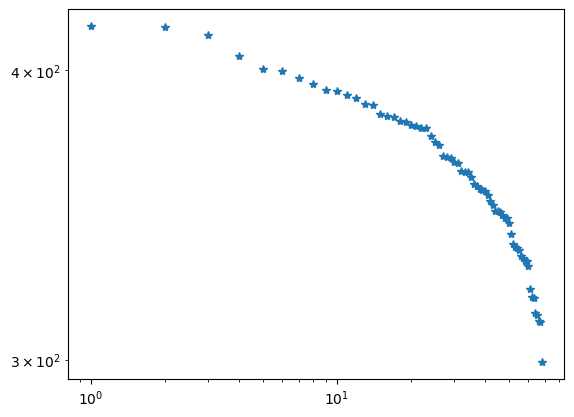

[390.0965 361.647  394.596  311.68   414.315  299.348  382.3265 391.616
 334.7005 399.6515 392.221  364.618  314.291  366.4995 340.0095 417.834
 400.502  361.7935 355.5645 347.874  357.3265 359.7795 313.6385 343.6885
 386.2015 319.3125 366.7805 345.1905 336.3955 405.6975 351.2415 371.387
 374.593  388.888  321.8415 378.931  346.3725 347.725  396.939  349.6695
 311.438  386.7435 353.4805 361.485  380.2865 356.4175 345.314  330.9985
 355.197  382.785  335.058  364.9925 354.826  329.2565 347.2945 332.702
 417.963  417.6395 378.2835 319.0675 379.7635 377.7835 332.0385 372.41
 335.6395 377.828  367.3515 331.034  381.908 ]


In [184]:
print(len(valid_strategies))

plt.loglog(np.sort(pumping_costs_sum[valid_strategies])[::-1],'*')
plt.show()


print(pumping_costs_sum[valid_strategies])



[166, 315, 589, 592, 689, 728, 844, 893, 922, 969, 1018, 1287, 1406, 1430, 1449, 1658, 1673, 1720, 1923, 2052, 2076, 2232, 2259, 2501, 2652, 2809, 3001, 3232, 3255, 3559, 3653, 3923, 3995, 4131, 4373, 5016, 5210, 5461, 5469, 5659, 5744, 5882, 6146, 6425, 6676, 6700, 6727, 6771, 6788, 6913, 7003, 7168, 7288, 7435, 7458, 7487, 7565, 7646, 7835, 8638, 8716, 9431, 9514, 9592, 9667, 9749, 9774, 9801, 9827]
5
728
299.348


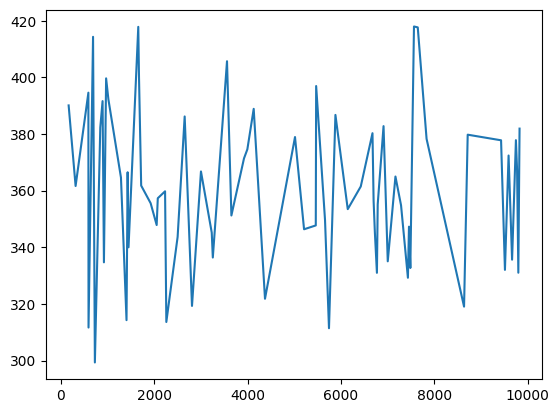

In [189]:
print(valid_strategies)

plt.plot(valid_strategies,pumping_costs_sum[valid_strategies])

print(np.argmin(pumping_costs_sum[valid_strategies]))

print(valid_strategies[np.argmin(pumping_costs_sum[valid_strategies])])

print(pumping_costs_sum[valid_strategies][np.argmin(pumping_costs_sum[valid_strategies])])

In [195]:
pumping_strategies[valid_strategies[np.argmin(pumping_costs_sum[valid_strategies])]]

array([4., 2., 4., 3., 2., 4., 1., 1., 1., 3., 4., 3., 4., 3., 3., 2., 3.,
       3., 1., 3., 4., 3., 1., 4., 3., 4., 4., 3., 3., 2., 1., 2., 2., 1.,
       4., 4., 2., 1., 2., 1., 1., 1., 1., 2., 4., 2., 4., 4., 2., 1., 4.,
       4., 2., 1., 4., 4., 3., 1., 4., 2., 2., 2., 1., 2., 4., 3., 3., 4.,
       1., 4., 4., 4., 1., 4., 3., 3., 3., 1., 3., 2., 1., 2., 1., 1., 3.,
       2., 2., 2., 3., 4., 4., 2., 4., 1., 1., 1.])

In [196]:
pumping_strategies[valid_strategies[np.argmin(pumping_costs_sum[valid_strategies])]]

plt.scatter(pumping_costs_sum[valid_strategies], future_electricity_prices[:len(valid_strategies)])
plt.xlabel('Pumping Cost')
plt.ylabel('Future Electricity Price')
plt.title('Pumping Costs vs Future Electricity Prices')
plt.show()


C:\Users\Svante\AppData\Local\Temp\ipykernel_21952\574664429.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [192]:
from datetime import datetime, timedelta
import numpy as np
from optimizer.visualize import visualize_results  # uses existing 6-panel plotting

def build_results_from_strategy(
    strategy,
    inflow_m3,
    prices_eur_per_kwh,
    start_datetime=None,
    interval_minutes=15,
    initial_volume_m3=0.0,
    initial_water_level_m=0.0,
    pump_flow_per_quantum_m3_per_interval=1600.0,
    power_kw_per_quantum=200.0,
    volume_to_level_fn=None,  # e.g., tunnel_height_from_volume
):
    """
    Build a results dict (compatible with visualize_results) from a chosen strategy.
    """
    strategy = np.asarray(strategy, dtype=float)
    inflow_m3 = np.asarray(inflow_m3, dtype=float)
    prices_eur_per_kwh = np.asarray(prices_eur_per_kwh, dtype=float)
    assert strategy.shape == inflow_m3.shape == prices_eur_per_kwh.shape, "Inputs must have same shape"

    N = strategy.shape[0]
    if start_datetime is None:
        start_datetime = datetime.utcnow()

    # Fallback simple volume->level mapping if none provided
    if volume_to_level_fn is None:
        denom = initial_volume_m3 if abs(initial_volume_m3) > 1e-9 else 1.0
        linear_scale = initial_water_level_m / denom
        def volume_to_level_fn(v):
            lvl = linear_scale * v
            return float(max(0.0, min(8.0, lvl)))  # clamp 0..8m

    pump_names = ['1.1', '1.2', '1.3', '1.4', '2.1', '2.2', '2.3', '2.4']

    schedule = []
    current_volume = float(initial_volume_m3)
    hours_per_interval = interval_minutes / 60.0
    total_cost = 0.0

    for t in range(N):
        quanta = float(strategy[t])
        price = float(prices_eur_per_kwh[t])
        inflow = float(inflow_m3[t])

        volume_start = current_volume
        level_start = volume_to_level_fn(volume_start)

        outflow = quanta * pump_flow_per_quantum_m3_per_interval
        volume_end = volume_start + inflow - outflow
        level_end = volume_to_level_fn(volume_end)

        # kWh = kW * h
        interval_kwh = power_kw_per_quantum * quanta * hours_per_interval
        interval_cost_eur = price * interval_kwh
        total_cost += interval_cost_eur

        # Simple efficiency proxy 60..100% from level
        efficiency_pct = 60.0 + (level_start / 8.0) * 40.0
        efficiency_pct = float(max(0.0, min(100.0, efficiency_pct)))

        pumping_score = price * (100.0 / max(1.0, efficiency_pct))  # lower is better

        # Map quanta to active pumps (ceil, capped at 8)
        num_active = int(np.ceil(quanta))
        num_active = max(0, min(len(pump_names), num_active))
        active_pumps = pump_names[:num_active]

        dt_py = start_datetime + timedelta(minutes=interval_minutes * t)
        date_str = dt_py.strftime('%Y-%m-%dT%H:%M:%S') + 'Z'

        schedule.append({
            'interval': t,
            'date': date_str,
            'water_level_start_m': level_start,
            'water_level_end_m': level_end,
            'volume_start_m3': volume_start,
            'volume_end_m3': volume_end,
            'inflow_m3': inflow,
            'outflow_m3': outflow,
            'electricity_price_eur_per_kwh': price,
            'pumping_score_eur_per_kwh': pumping_score,
            'pump_efficiency_pct': efficiency_pct,
            'interval_cost_eur': interval_cost_eur,
            'active_pumps': active_pumps,
        })

        current_volume = volume_end

    results = {
        'schedule': schedule,
        'total_cost_eur': float(total_cost),
        'initial_water_level_m': float(initial_water_level_m),
        'initial_volume_m3': float(initial_volume_m3),
        'interval_minutes': int(interval_minutes),
    }
    return results


def visualize_strategy(
    strategy,
    inflow_m3,
    prices_eur_per_kwh,
    start_datetime=None,
    interval_minutes=15,
    initial_volume_m3=0.0,
    initial_water_level_m=0.0,
    pump_flow_per_quantum_m3_per_interval=1600.0,
    power_kw_per_quantum=200.0,
    volume_to_level_fn=None,  # e.g., tunnel_height_from_volume
):
    """
    Build results from the chosen strategy and render the same 6-panel visualization.
    Returns the saved image path from visualize_results.
    """
    results = build_results_from_strategy(
        strategy=strategy,
        inflow_m3=inflow_m3,
        prices_eur_per_kwh=prices_eur_per_kwh,
        start_datetime=start_datetime,
        interval_minutes=interval_minutes,
        initial_volume_m3=initial_volume_m3,
        initial_water_level_m=initial_water_level_m,
        pump_flow_per_quantum_m3_per_interval=pump_flow_per_quantum_m3_per_interval,
        power_kw_per_quantum=power_kw_per_quantum,
        volume_to_level_fn=volume_to_level_fn,
    )
    return visualize_results(results)

In [194]:
# Choose strategy with minimum cost among valid ones
chosen = pumping_strategies[valid_strategies[np.argmin(pumping_costs_sum[valid_strategies])]]

# If your series already in €/kWh, keep as-is; otherwise convert from cents:
prices_eur = future_electricity_prices  # or: future_electricity_prices / 100.0

# Use your physical converter if available
# from your notebook: tunnel_height_from_volume
out_path = visualize_strategy(
    strategy=chosen,
    inflow_m3=inflow_to_tunnel_f1,
    prices_eur_per_kwh=prices_eur,
    start_datetime=df['Time stamp'][0],
    interval_minutes=15,
    initial_volume_m3=initial_volume,
    initial_water_level_m=initial_water_level,
    pump_flow_per_quantum_m3_per_interval=pump_flow_per_quantum,
    power_kw_per_quantum=200.0,
    volume_to_level_fn=tunnel_height_from_volume,  # or None to use linear fallback
)
print("Saved to:", out_path)

c:\Users\Svante\Hacking\valmet_HSY_sewage\optimizer\visualize.py:201: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



✓ Visualization saved to optimization_visualization.png
Saved to: optimization_visualization.png
